#  Spatio-Temporal Analysis

In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=246101e923681861f2d9604350b1c44f26dd46bace33d86ac04a7bb229faf6d3
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
import pyspark
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pyspark.sql  as pyspark_sql
import pyspark.sql.types as pyspark_types
import pyspark.sql.functions  as F
from pyspark import SparkContext, SparkConf
from pyspark.sql import Window
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [4]:
# Load datasets
df = spark.read.csv("Dataset/Preprocessed/cleaned_data.csv", header=True, inferSchema=True)
df_pd = df.toPandas()

## Analyzing Trends Over Time

In [5]:
# Function to get data to plot seasonal decompositions
def get_seasonal_data():
    seasonal_df = df.select("Current Date", "HCHO reading", "Location").toPandas()

    # Convert the Current Date column to datetime
    seasonal_df["Current Date"] = pd.to_datetime(seasonal_df["Current Date"])
    # Set date as the index
    seasonal_df.set_index("Current Date", inplace=True, drop=True)

    return seasonal_df

In [6]:
def plot_seasonal_decomposition(location_df, location_name):
    # Filter data for the specific location
    location_df = location_df[location_df["Location"] == location_name]

    # Decompose the time series
    decompose = seasonal_decompose(location_df["HCHO reading"], model='additive', period=365)

    # Plot the decomposition
    fig, axes = plt.subplots(4, 1, figsize=(15, 18))
    fig.suptitle(f"Seasonal Decomposition of HCHO Readings in {location_name}", fontsize=14, y=0.95)

    # Plot the original data
    decompose.observed.plot(ax=axes[0])
    axes[0].set_ylabel('Original')

    # Show lockdown periods
    axes[0].axvspan('2020-03-01', '2020-06-28', color='#bb0606', alpha=0.3, label='Lockdown Period 1')
    axes[0].axvspan('2021-08-01', '2021-10-30', color='#196a0b', alpha=0.3, label='Lockdown Period 2')

    axes[0].legend(loc='upper right')

    # Plot the trend component - Long-term progression or direction of the data, ignoring the short-term fluctuations and noise.
    decompose.trend.plot(ax=axes[1],label='Trend')
    axes[1].set_ylabel('Trend')

    # Show lockdown periods
    axes[1].axvspan('2020-03-01', '2020-06-28', color='#bb0606', alpha=0.3, label='Lockdown Period 1')
    axes[1].axvspan('2021-08-01', '2021-10-30', color='#196a0b', alpha=0.3, label='Lockdown Period 2')

    axes[1].legend(loc='upper right')

    # Plot the seasonal component - Repetitive, periodic patterns in the data that occur at regular intervals.
    decompose.seasonal.plot(ax=axes[2],label='Seasonal')
    axes[2].set_ylabel('Seasonal')
    axes[2].legend(loc='upper right')

    # Plot the residual component -  Random fluctuations or noise in the data that cannot be explained by the trend or seasonal components.
    decompose.resid.plot(ax=axes[3],label='Residual')
    axes[3].set_ylabel('Residual')
    axes[3].legend(loc='upper right')

    plt.subplots_adjust(top=0.925, hspace=0.20)
    plt.show()
    print("\n")


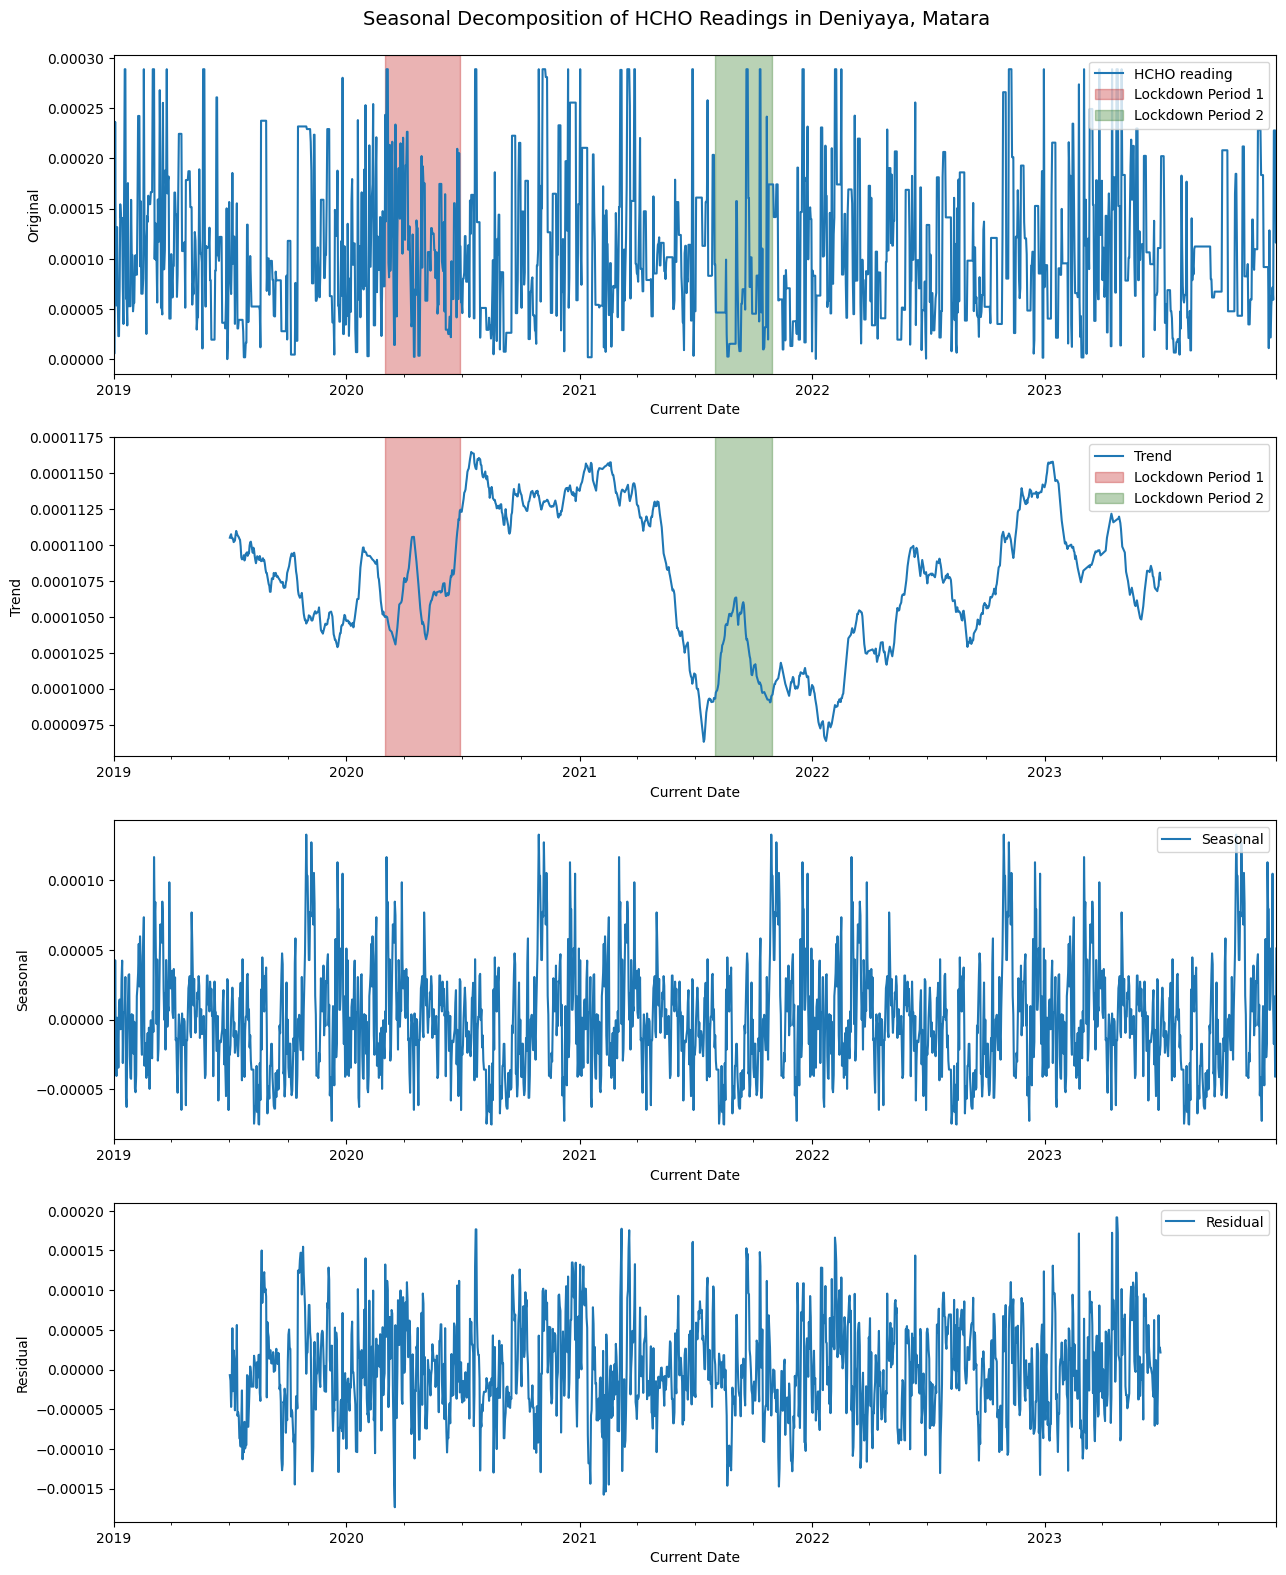

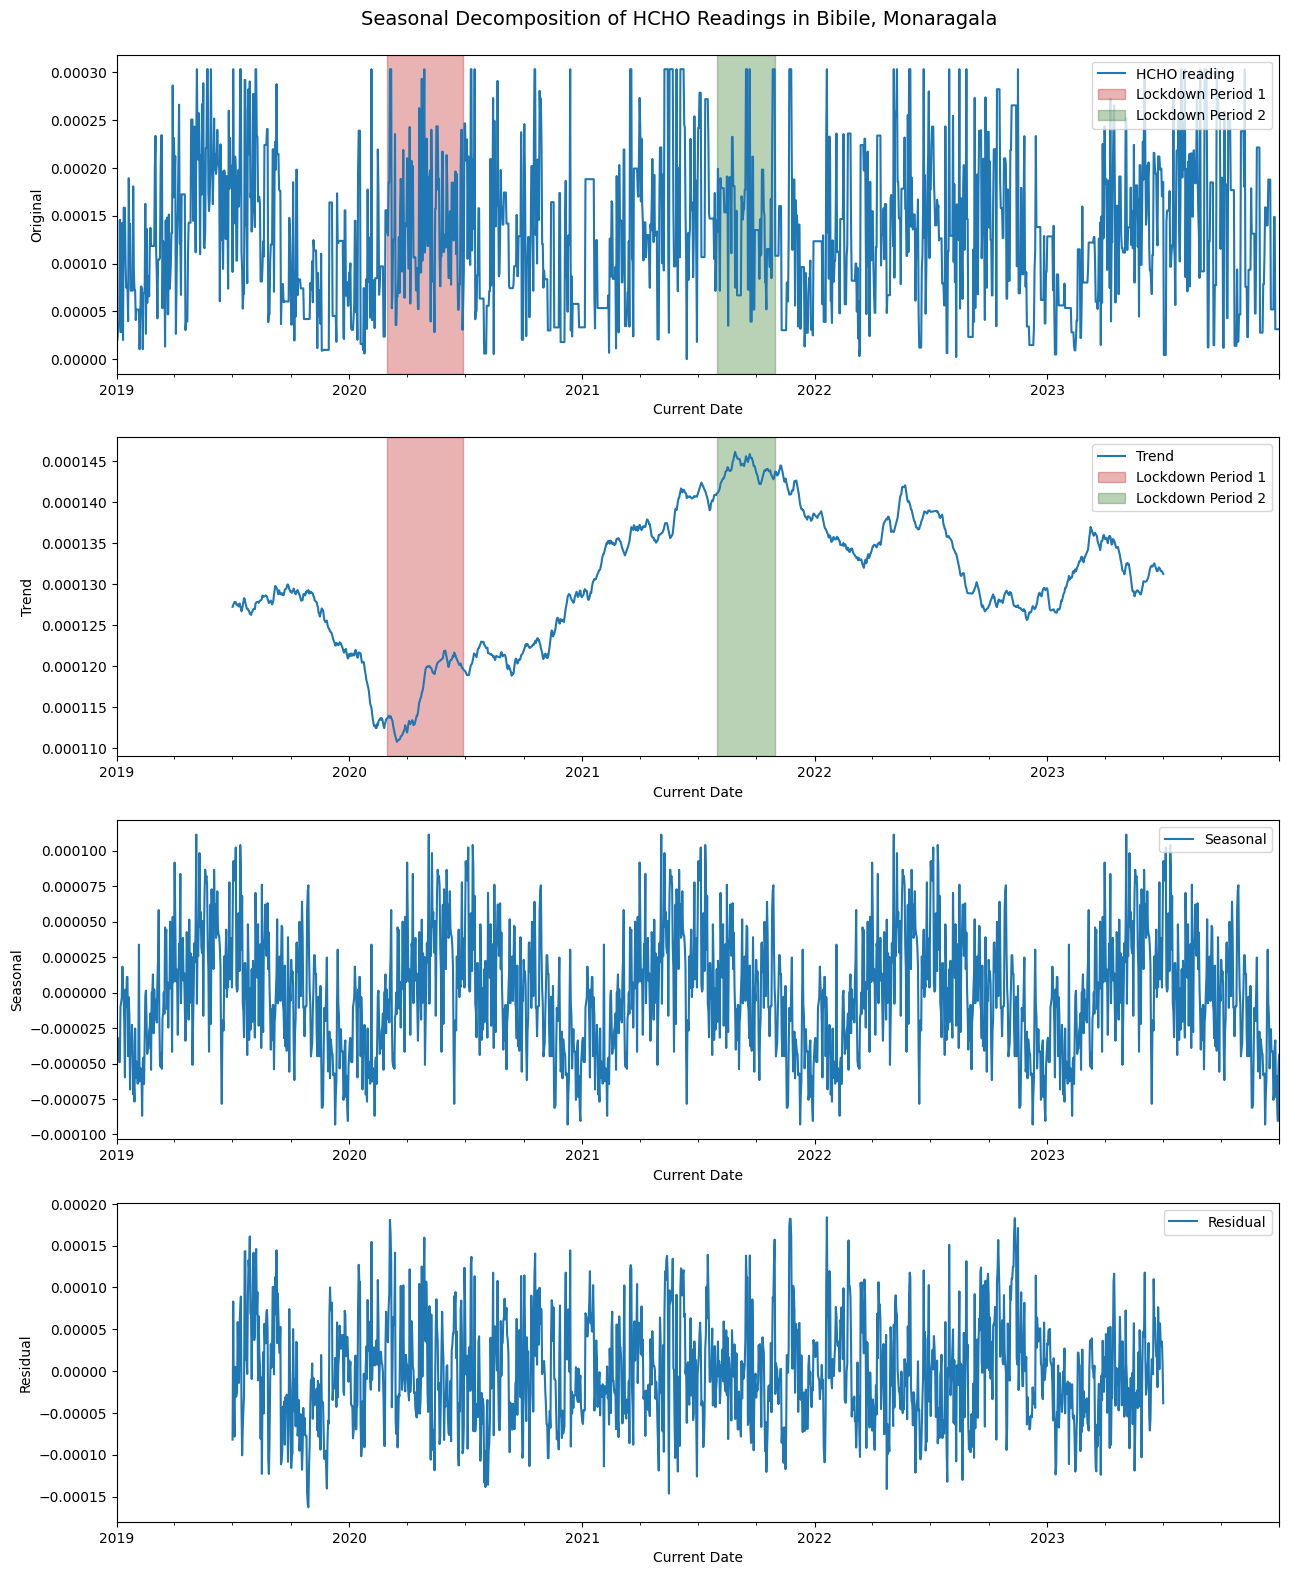

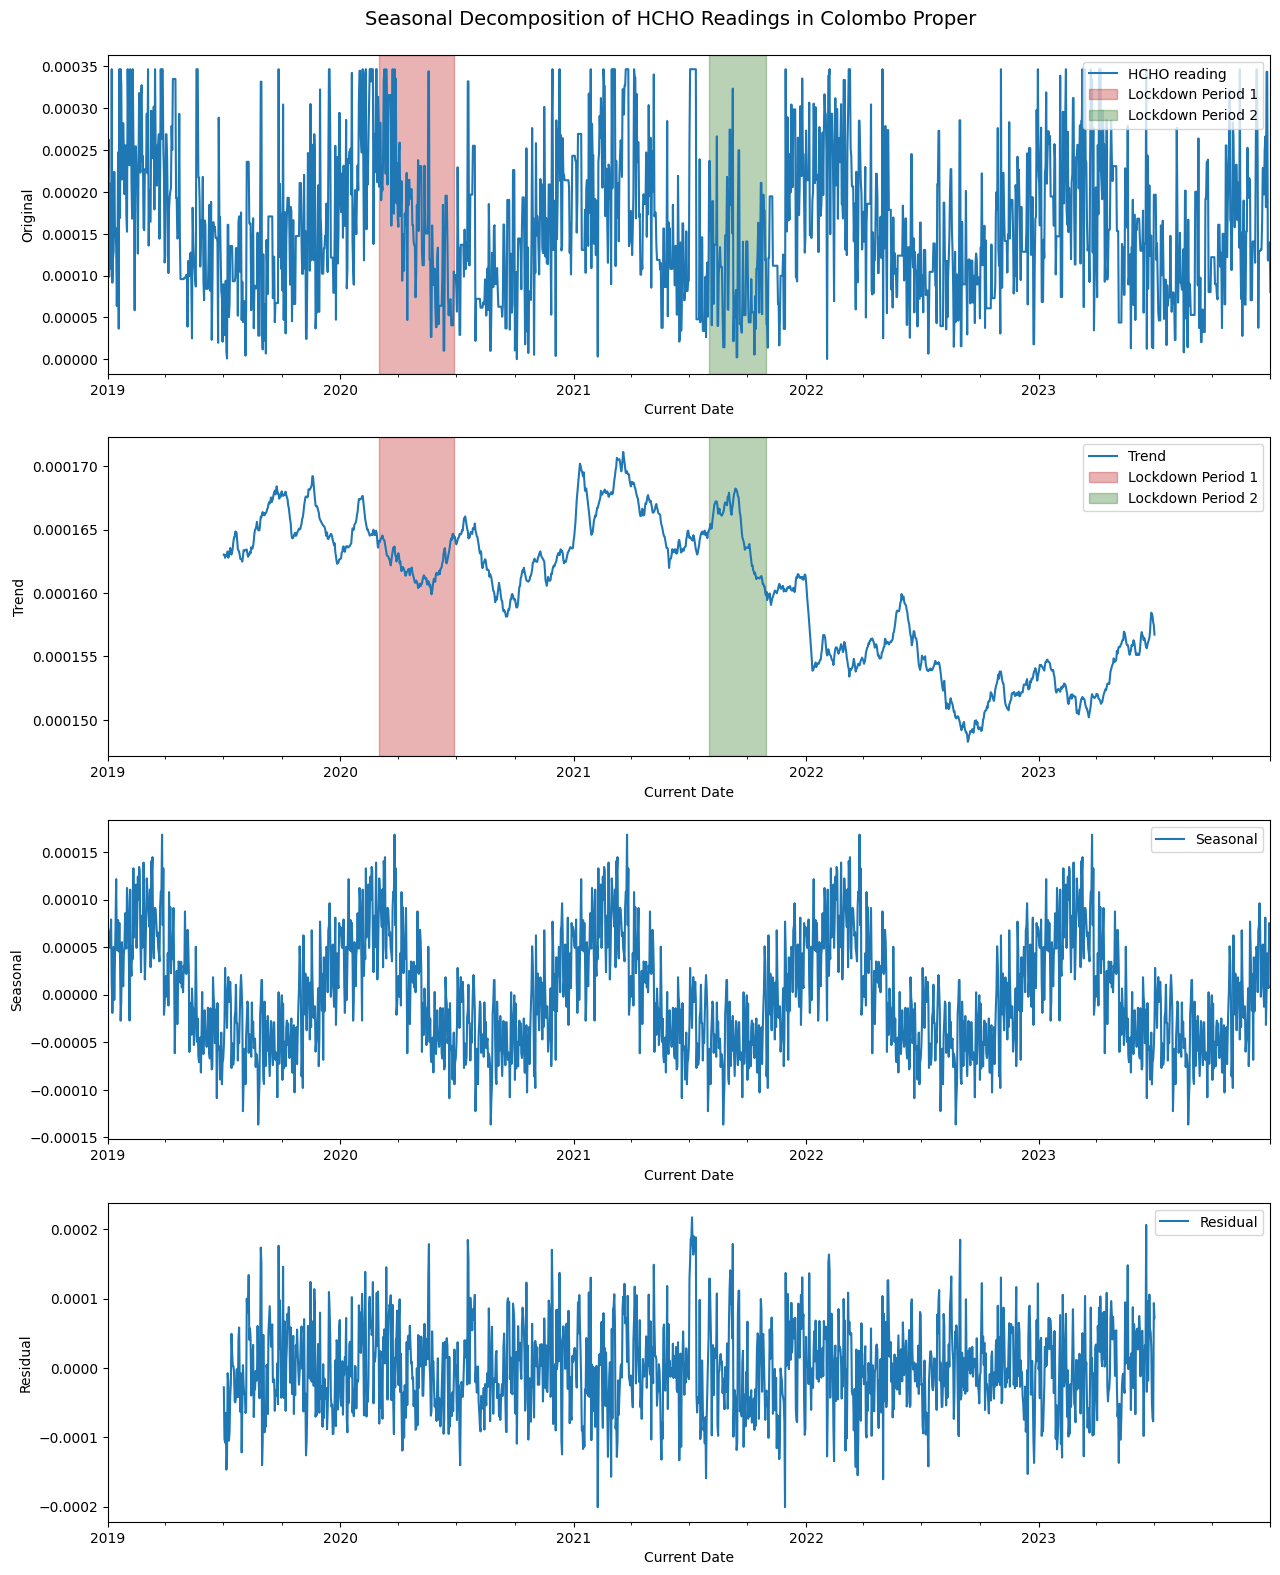

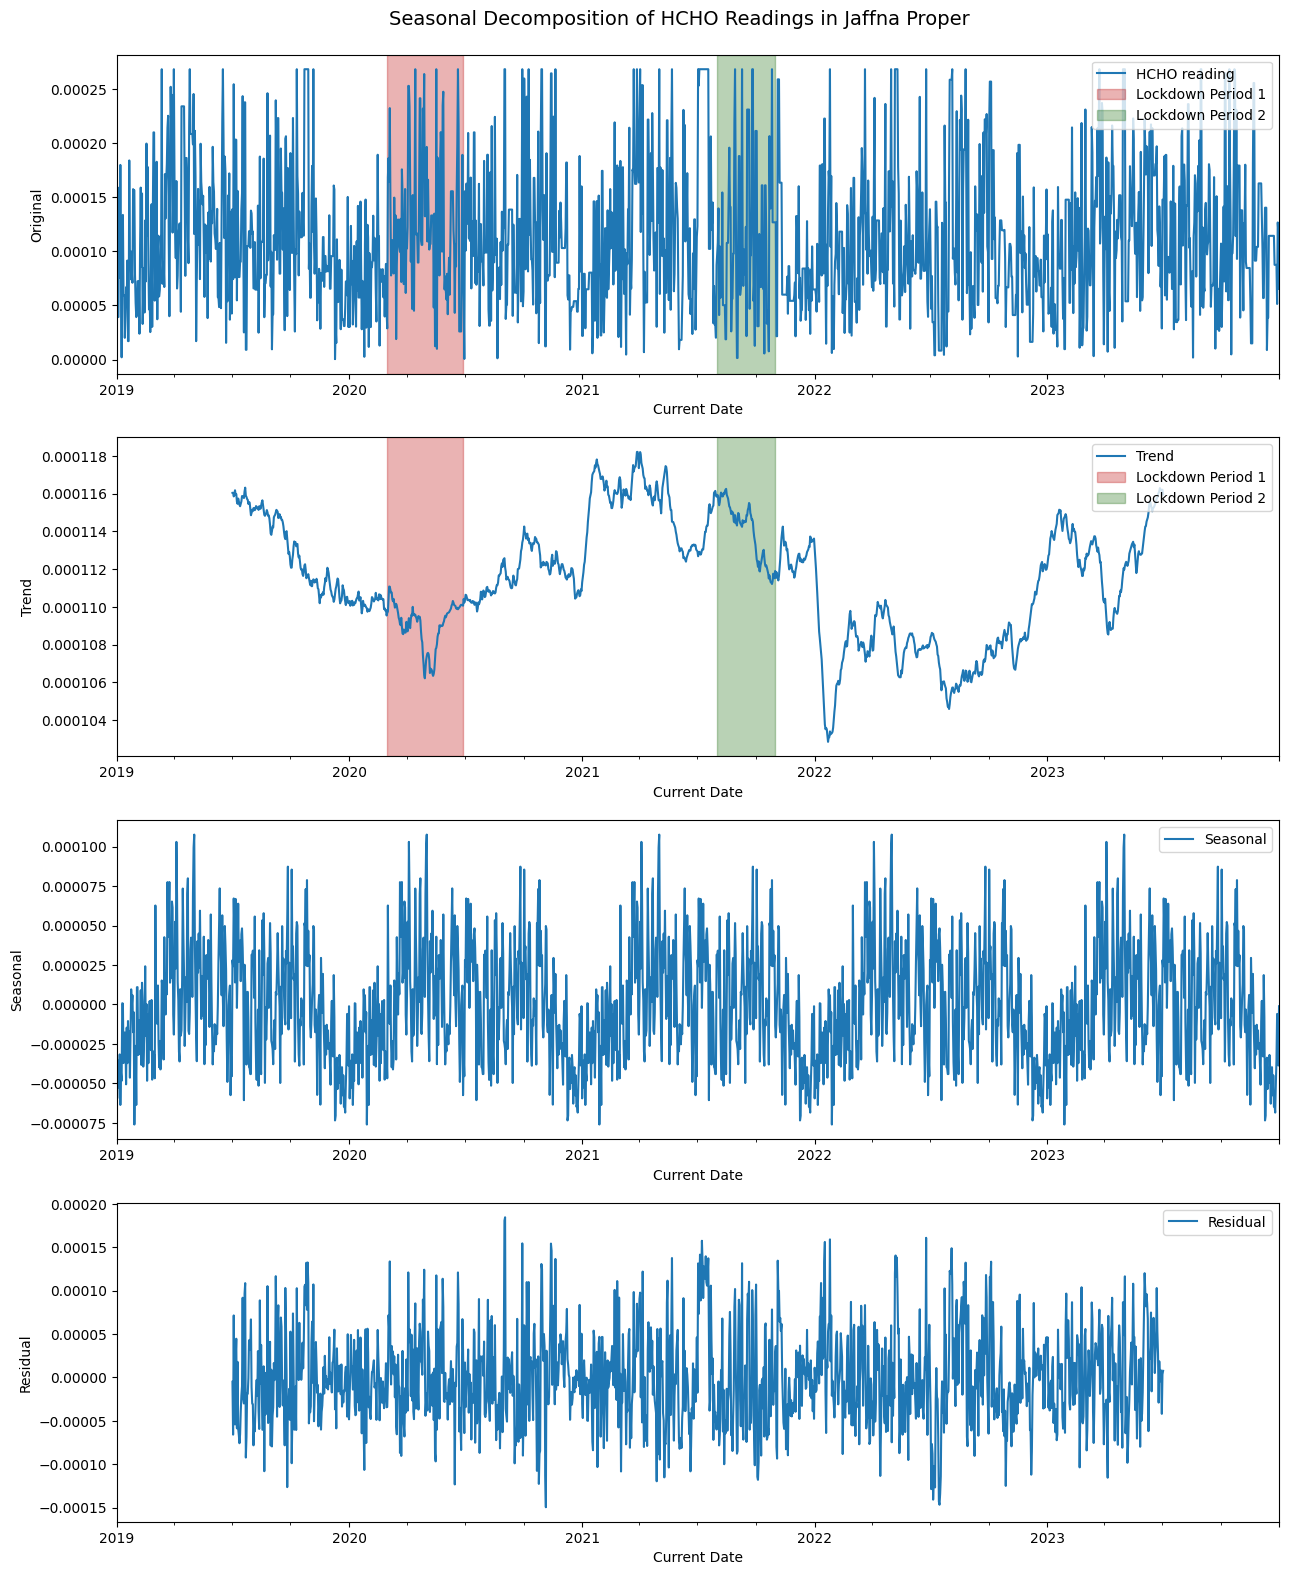

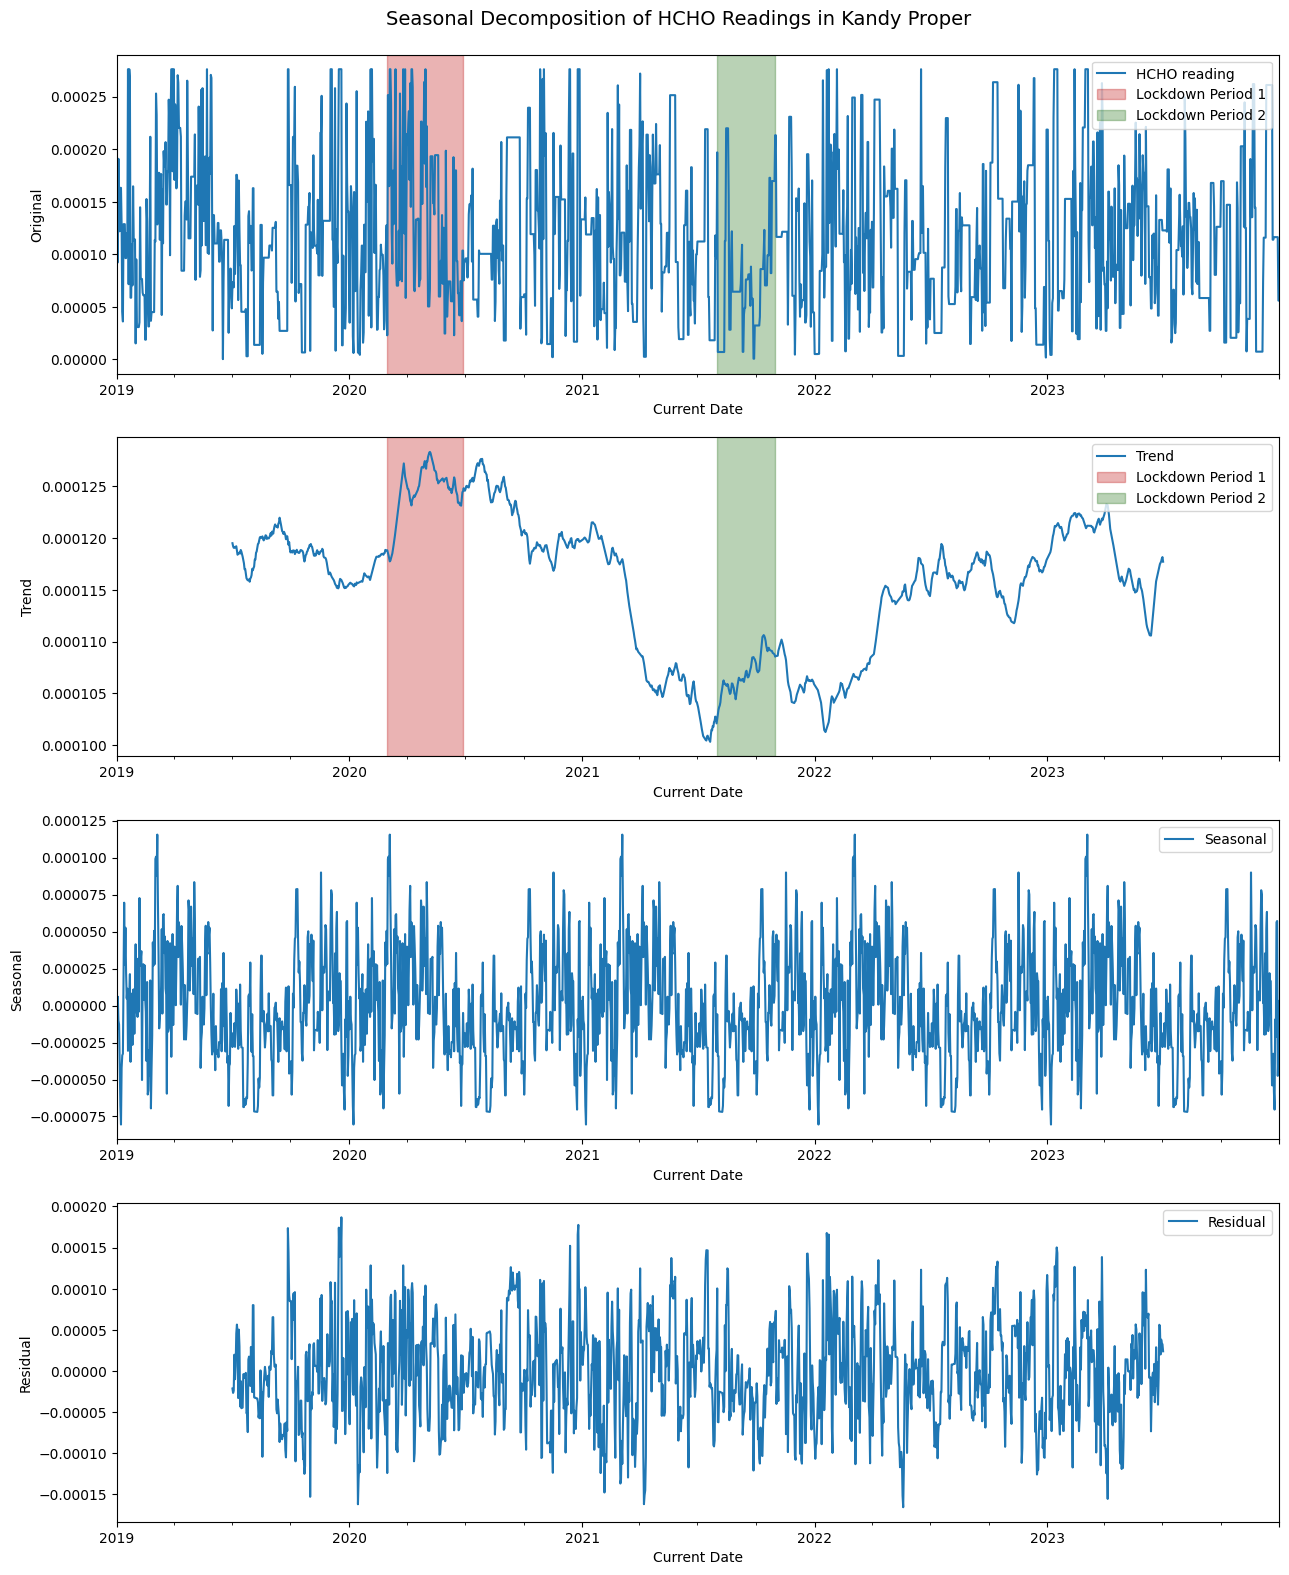

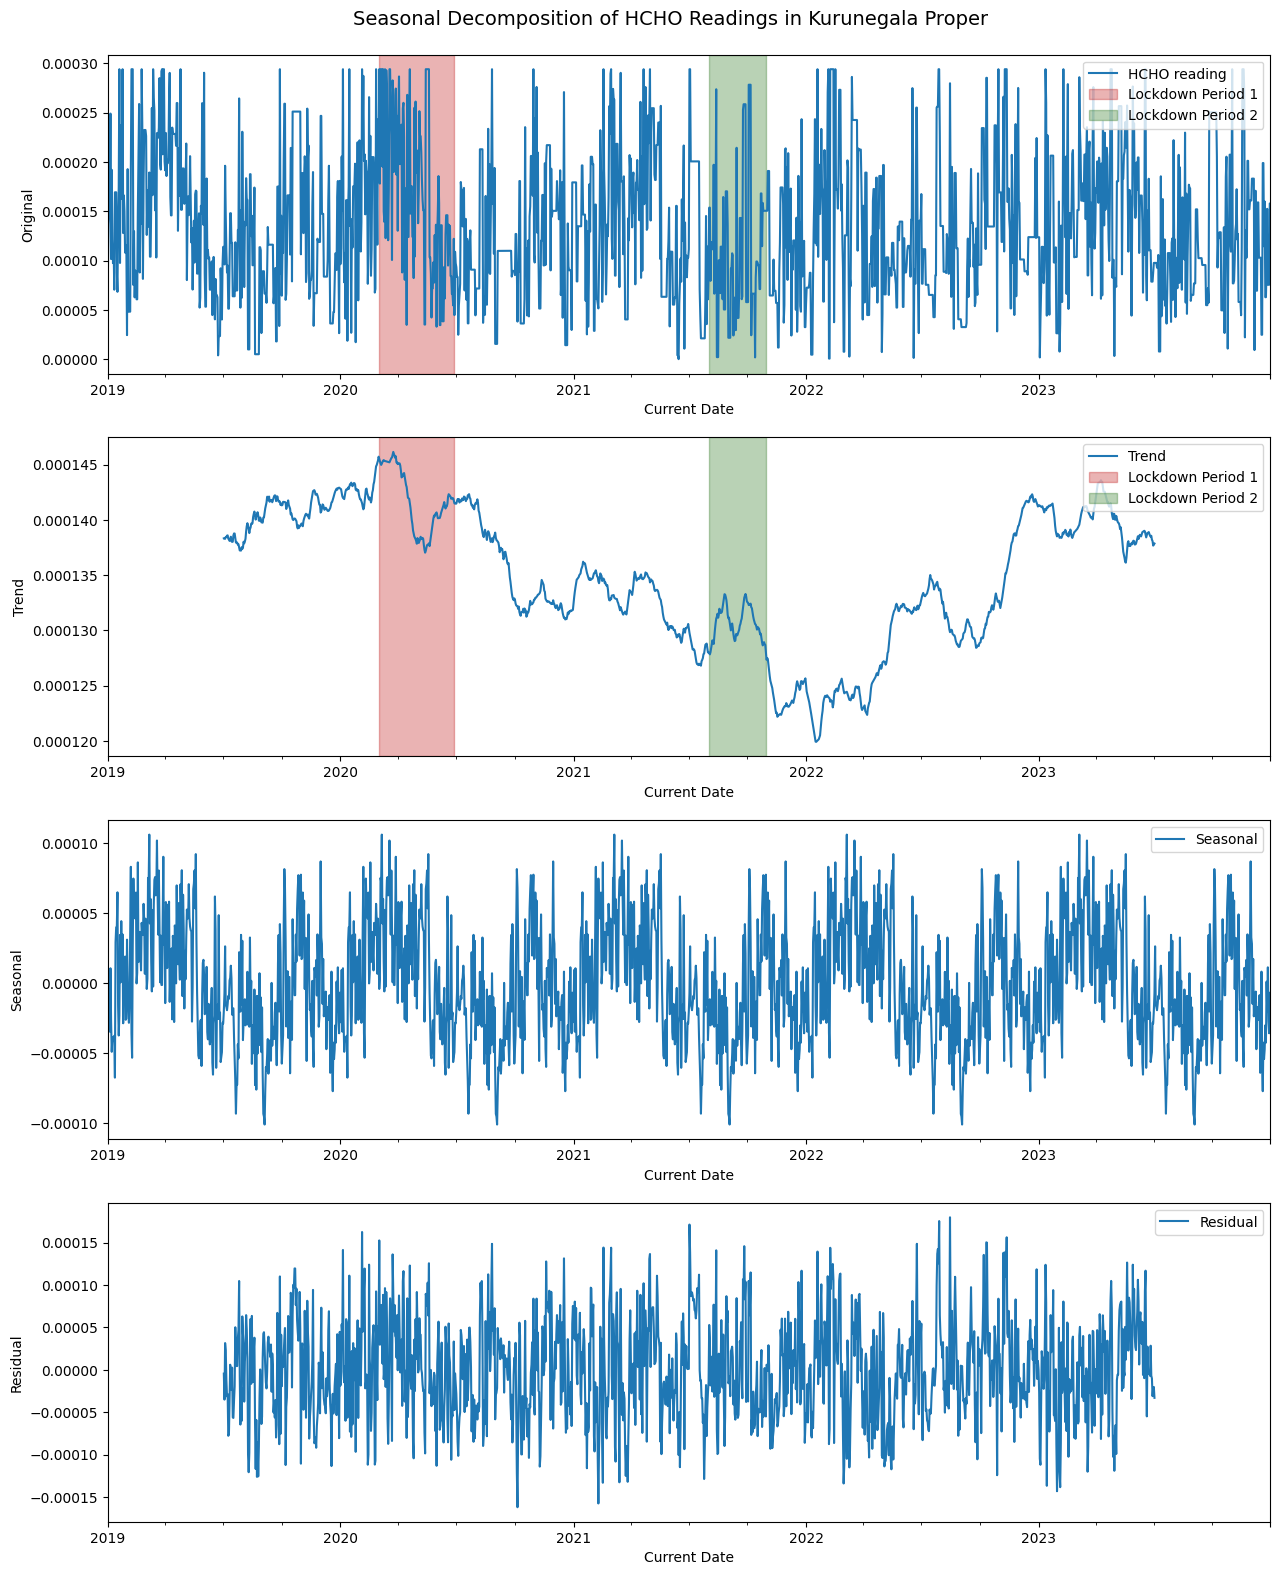

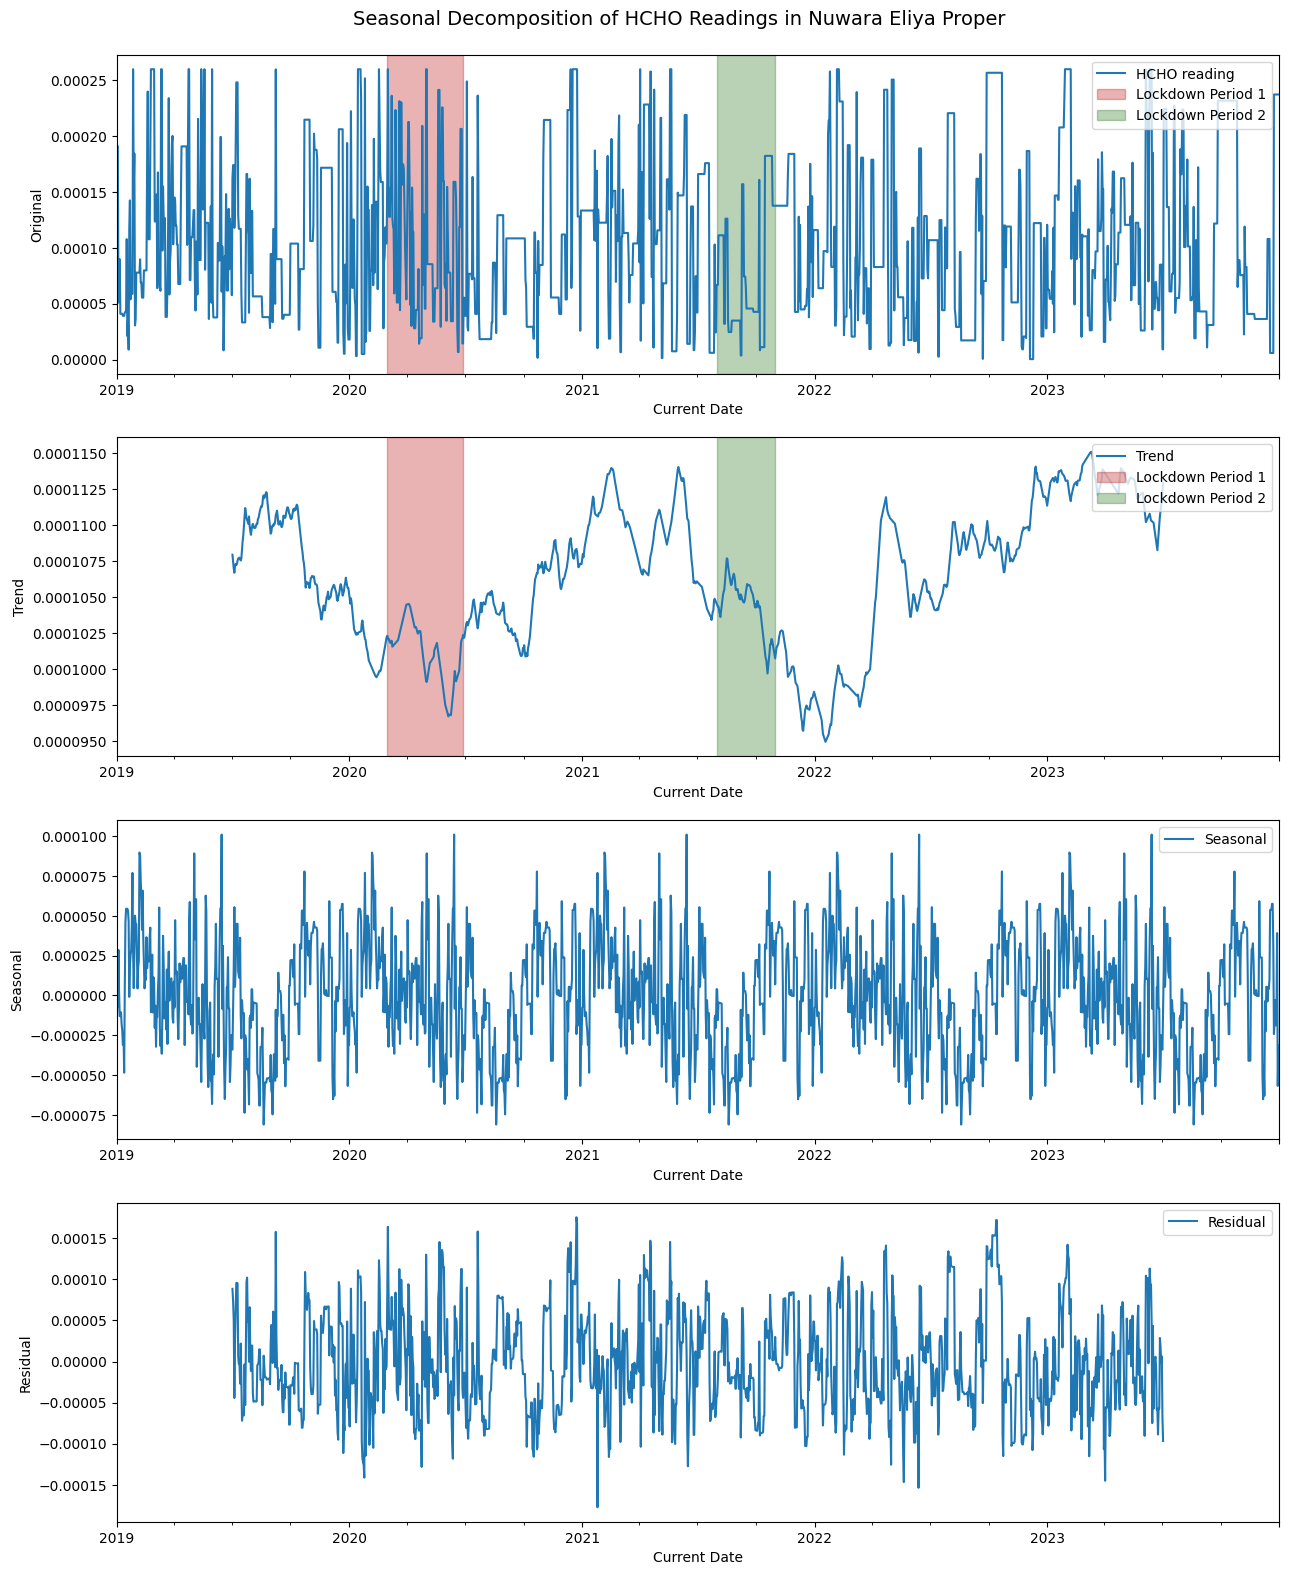

In [7]:
# Load the data
df = get_seasonal_data()

# List of locations
locations = ["Deniyaya, Matara", "Bibile, Monaragala", "Colombo Proper", "Jaffna Proper", "Kandy Proper", "Kurunegala Proper", "Nuwara Eliya Proper"]

# Plot seasonal decomposition of each location
for location_name in locations:
    location_data = df[df["Location"] == location_name]
    plot_seasonal_decomposition(df, location_name)

## Analyzing Correlation of HCHO levels with external factors

Weather Dataset #1 (Kaggle)

In [37]:
# Load datasets
weather_df = spark.read.csv("Dataset/ExternalFactors/SriLanka_Weather_Dataset.csv", header=True, inferSchema=True)
weather_df_pd = weather_df.toPandas()

In [38]:
# Get unique cities
print(weather_df_pd["city"].unique())


['Colombo' 'Mount Lavinia' 'Kesbewa' 'Moratuwa' 'Maharagama' 'Ratnapura'
 'Kandy' 'Negombo' 'Sri Jayewardenepura Kotte' 'Kalmunai' 'Trincomalee'
 'Galle' 'Jaffna' 'Athurugiriya' 'Weligama' 'Matara' 'Kolonnawa' 'Gampaha'
 'Puttalam' 'Badulla' 'Kalutara' 'Bentota' 'Matale' 'Mannar' 'Pothuhera'
 'Kurunegala' 'Mabole' 'Hatton' 'Hambantota' 'Oruwala']


In [39]:
# Remove unwanted cities
cities_to_keep = ['Colombo', 'Kandy', 'Jaffna', 'Matara', 'Kurunegala']
weather_df = weather_df.filter(weather_df["city"].isin(cities_to_keep))
weather_df_pd = weather_df.toPandas()
print(weather_df_pd["city"].unique())

['Colombo' 'Kandy' 'Jaffna' 'Matara' 'Kurunegala']


In [40]:
weather_df.show(5)

+----------+-----------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+-------------------+-------------------+-----------------------+-----------------+--------+------------+-------------------+-----------------+-----------------+--------------------------+--------------------------+--------+---------+---------+---------+-------+
|      time|weathercode|temperature_2m_max|temperature_2m_min|temperature_2m_mean|apparent_temperature_max|apparent_temperature_min|apparent_temperature_mean|            sunrise|             sunset|shortwave_radiation_sum|precipitation_sum|rain_sum|snowfall_sum|precipitation_hours|windspeed_10m_max|windgusts_10m_max|winddirection_10m_dominant|et0_fao_evapotranspiration|latitude|longitude|elevation|  country|   city|
+----------+-----------+------------------+------------------+-------------------+------------------------+------------------------+-------------------------+--

In [80]:
num_rows = weather_df.count()
print("Number of rows in full dataset:", num_rows)

Number of rows in full dataset: 8145


In [41]:
# Remove unwanted columns
columns_to_keep = ['time', 'temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean', 'precipitation_sum', 'latitude', 'longitude','elevation', 'city']
weather_df = weather_df.select([F.col(column) for column in columns_to_keep])
weather_df.show()


+----------+------------------+------------------+-------------------+-----------------+--------+---------+---------+-------+
|      time|temperature_2m_max|temperature_2m_min|temperature_2m_mean|precipitation_sum|latitude|longitude|elevation|   city|
+----------+------------------+------------------+-------------------+-----------------+--------+---------+---------+-------+
|2010-01-01|              30.0|              22.7|               26.1|              0.0|     7.0|79.899994|     16.0|Colombo|
|2010-01-02|              29.9|              23.5|               26.2|              0.1|     7.0|79.899994|     16.0|Colombo|
|2010-01-03|              29.5|              23.2|               26.0|              0.6|     7.0|79.899994|     16.0|Colombo|
|2010-01-04|              28.9|              21.9|               25.3|              0.0|     7.0|79.899994|     16.0|Colombo|
|2010-01-05|              28.1|              21.3|               24.5|              0.0|     7.0|79.899994|     16.0|C

In [42]:
# Rename column names
weather_df = weather_df.toDF("time","temperature_2m_max","temperature_2m_min","temperature_2m_mean","precipitation_sum","latitude","longitude","elevation","city").withColumnRenamed("time", "Date").withColumnRenamed("temperature_2m_max", "Temperature Max").withColumnRenamed("temperature_2m_min", "Temperature Min").withColumnRenamed("temperature_2m_mean", "Temperature Average").withColumnRenamed("precipitation_sum", "Precipitation").withColumnRenamed("latitude", "Latitude").withColumnRenamed("longitude", "Longitude").withColumnRenamed("elevation", "Elevation").withColumnRenamed("city", "Location")

# Show DataFrame with renamed columns
weather_df.show(5)

+----------+---------------+---------------+-------------------+-------------+--------+---------+---------+--------+
|      Date|Temperature Max|Temperature Min|Temperature Average|Precipitation|Latitude|Longitude|Elevation|Location|
+----------+---------------+---------------+-------------------+-------------+--------+---------+---------+--------+
|2010-01-01|           30.0|           22.7|               26.1|          0.0|     7.0|79.899994|     16.0| Colombo|
|2010-01-02|           29.9|           23.5|               26.2|          0.1|     7.0|79.899994|     16.0| Colombo|
|2010-01-03|           29.5|           23.2|               26.0|          0.6|     7.0|79.899994|     16.0| Colombo|
|2010-01-04|           28.9|           21.9|               25.3|          0.0|     7.0|79.899994|     16.0| Colombo|
|2010-01-05|           28.1|           21.3|               24.5|          0.0|     7.0|79.899994|     16.0| Colombo|
+----------+---------------+---------------+-------------------+

In [43]:
# Rename the 'city' column
weather_df = weather_df.withColumn("Location",
    F.when(F.col("Location") == "Colombo", "Colombo Proper")
    .when(F.col("Location") == "Kandy", "Kandy Proper")
    .when(F.col("Location") == "Jaffna", "Jaffna Proper")
    .when(F.col("Location") == "Matara", "Deniyaya, Matara")
    .when(F.col("Location") == "Kurunegala", "Kurunegala Proper")
    .otherwise(F.col("Location")))

weather_df_pd = weather_df.toPandas()
print(weather_df_pd["Location"].unique())

['Colombo Proper' 'Kandy Proper' 'Jaffna Proper' 'Deniyaya, Matara'
 'Kurunegala Proper']


In [44]:
weather_df.show(5)

+----------+---------------+---------------+-------------------+-------------+--------+---------+---------+--------------+
|      Date|Temperature Max|Temperature Min|Temperature Average|Precipitation|Latitude|Longitude|Elevation|      Location|
+----------+---------------+---------------+-------------------+-------------+--------+---------+---------+--------------+
|2010-01-01|           30.0|           22.7|               26.1|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
|2010-01-02|           29.9|           23.5|               26.2|          0.1|     7.0|79.899994|     16.0|Colombo Proper|
|2010-01-03|           29.5|           23.2|               26.0|          0.6|     7.0|79.899994|     16.0|Colombo Proper|
|2010-01-04|           28.9|           21.9|               25.3|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
|2010-01-05|           28.1|           21.3|               24.5|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
+----------+----

In [45]:
print(weather_df_pd["Date"].unique())

[datetime.date(2010, 1, 1) datetime.date(2010, 1, 2)
 datetime.date(2010, 1, 3) ... datetime.date(2023, 6, 15)
 datetime.date(2023, 6, 16) datetime.date(2023, 6, 17)]


In [46]:
# Filter the date range
weather_df = weather_df.filter((F.col("Date") >= "2019-01-01") & (F.col("Date") <= "2023-12-31"))

# Show the filtered DataFrame
weather_df.show()

+----------+---------------+---------------+-------------------+-------------+--------+---------+---------+--------------+
|      Date|Temperature Max|Temperature Min|Temperature Average|Precipitation|Latitude|Longitude|Elevation|      Location|
+----------+---------------+---------------+-------------------+-------------+--------+---------+---------+--------------+
|2019-01-01|           30.0|           23.1|               26.1|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
|2019-01-02|           29.4|           22.7|               25.7|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
|2019-01-03|           30.2|           22.6|               26.1|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
|2019-01-04|           30.6|           22.3|               26.0|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
|2019-01-05|           31.1|           22.6|               26.4|          0.0|     7.0|79.899994|     16.0|Colombo Proper|
|2019-01-06|    

In [61]:
weather_df_pd = weather_df.toPandas()
print(weather_df_pd["Date"].unique())

[datetime.date(2019, 1, 1) datetime.date(2019, 1, 2)
 datetime.date(2019, 1, 3) ... datetime.date(2023, 6, 15)
 datetime.date(2023, 6, 16) datetime.date(2023, 6, 17)]


In [47]:
# Null value count
null_value_count = weather_df.select([F.sum(F.when(F.col(column).isNull(), 1).otherwise(0)).alias(column) for column in weather_df.columns])

null_value_count.show()

+----+---------------+---------------+-------------------+-------------+--------+---------+---------+--------+
|Date|Temperature Max|Temperature Min|Temperature Average|Precipitation|Latitude|Longitude|Elevation|Location|
+----+---------------+---------------+-------------------+-------------+--------+---------+---------+--------+
|   0|              0|              0|                  0|            0|       0|        0|        0|       0|
+----+---------------+---------------+-------------------+-------------+--------+---------+---------+--------+



In [48]:
# Count the duplicate rows
duplicate_count = weather_df.groupBy(weather_df.columns).count().where(F.col("count") > 1).count()

# Show the count of duplicate rows
print("Number of duplicate rows:", duplicate_count)

Number of duplicate rows: 0
